In [1]:
import pandas as pd
import sys
sys.path.append('..')  # Adjust the path based on your project structure
import json
import re
import ast
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
import os.path as osp
from glob import glob
import datetime

In [45]:
from pathlib import Path
def load_and_parse_txt(path_or_list, feature_names, file_names):
    # Read the text file into a list of lines
    if isinstance(path_or_list, list):
        
        df_list = []
        logit_columns_list = []
        pred_columns_list = []
        gt_columns_list = []
        for p in path_or_list:
            df, logit_columns, pred_columns, gt_columns = load_and_parse_txt(p, feature_names, file_names)
            df_list.append(df)
            logit_columns_list.append(logit_columns)
            pred_columns_list.append(pred_columns)
            gt_columns_list.append(gt_columns)
        return pd.concat(df_list), logit_columns_list, pred_columns_list, gt_columns_list
    elif isinstance(path_or_list, str):
        path = path_or_list

    with open(path, 'r') as file:
        lines = file.readlines()
    


    # Extract relevant information from each line
    data = []
    indecies = []
    for line in lines[1:]:

        
        # Use regex to find index, predictions, and targets
        # match = re.match(r'(\d+)\s+\[([^\]]+)\]\s+\[([^\]]+)\]\s+(\d+)\s+(\d+)', line.strip())
        match = re.match(r'(\d+\-[^ ]+)\s+\[([^\]]+)\]\s+\[([^\]]+)\]\s+(\d+)\s+(\d+)', line.strip())
        if match:
    

            # index = int(match.group(1))
            index = match.group(1)
            
            # Extract model predictions and convert to list using ast
            logits_str = match.group(2)
            logits = list(ast.literal_eval(logits_str))
            
            predictions = ((np.array(logits)>0.5).astype(int)).tolist()


            # Extract targets and convert to list using ast
            targets_str = f'[{match.group(3)}]'
            targets = list(np.array(ast.literal_eval(targets_str)))

            
            row_data = logits + predictions + targets 
            row_data = np.array(row_data)
            data.append(row_data)
            # indecies.append(int(index))
            indecies.append(index)

    # Create column names
    logit_columns = [f"logit-{name}" for name in feature_names]
    pred_columns = [f"pred-{name}" for name in feature_names]
    gt_columns = [f"gt-{name}" for name in feature_names]
    columns = logit_columns + pred_columns + gt_columns 

    # Create Pandas DataFrame
    df = pd.DataFrame(data, columns=columns, index=indecies)
    df[pred_columns+gt_columns] = df[pred_columns+gt_columns].astype(int)
    # print(df.iloc[0])
    # print(df.tail(1))
    df['filenames'] = file_names
    df['log_name'] = osp.basename(path)

    return df, logit_columns, pred_columns, gt_columns
    # return data, columns


In [43]:
experiment_folder = '/home/ubuntu/efs/videoMAE/scripts/MPIIGroupInteraction'
run_name = 'videomae_vit_base_patch16_224_kinetic_400_densepose_dual'

In [36]:
# path_to_weights = '/home/ubuntu/efs/videoMAE/scripts/dyadic_communication_001/dataset/weights.json'
# experiment_folder = '/home/ubuntu/efs/videoMAE/scripts/dyadic_communication_5vid_clean'
# run_name = 'videomae_vit_base_patch16_224_tubemasking_ratio_0.9_kinetic_400'
path_to_weights = osp.join(experiment_folder,run_name,'dataset/weights.json')
with open(path_to_weights, 'r') as json_file:
    positive_weights_dict = json.load(json_file)

        
feature_names = [entry['class'] for entry in positive_weights_dict['data']]

In [37]:
feature_names

['Adjusting_clothing',
 'Fold_arms',
 'Fumble',
 'Gesture',
 'Groom',
 'Hand_face',
 'Hand_mouth',
 'Leg_movement',
 'Legs_crossed',
 'Scratch',
 'Settle',
 'Shrug',
 'Smearing_hands',
 'Stretching']

In [46]:
path_to_log = glob(osp.join(experiment_folder,run_name,'eval','*.txt'))
# path_to_dataset = osp.join(experiment_folder,run_name,'dataset','test.csv')
path_to_dataset = osp.join(experiment_folder,run_name,'dataset','val.csv')
# Get names of file names from the csv file
df_csv = pd.read_csv(path_to_dataset)
file_names = df_csv['filenames'].tolist()
metadata = df_csv['metadata'].tolist()
df, logit_columns, pred_columns, gt_columns = load_and_parse_txt(path_to_log, feature_names,file_names)
# data, columns = load_and_parse_txt(path_to_log, feature_names)
df = df.drop(columns='log_name').groupby('filenames').mean()
logit_columns=logit_columns[0]
pred_columns=pred_columns[0]
gt_columns=gt_columns[0]

logits=[0.115966796875, 0.00017952919006347656, 0.005405426025390625, 0.0222930908203125, 0.0003249645233154297, 0.0006566047668457031, 6.455183029174805e-05, 0.034027099609375, 0.9990234375, 0.0177764892578125, 0.1778564453125, 0.0011968612670898438, 0.1551513671875, 0.002834320068359375]


ValueError: invalid literal for int() with base 10: '04298-video1'

In [41]:
df.head()


,logit-Adjusting_clothing,logit-Fold_arms,logit-Fumble,logit-Gesture,logit-Groom,logit-Hand_face,logit-Hand_mouth,logit-Leg_movement,logit-Legs_crossed,logit-Scratch,...,gt-Groom,gt-Hand_face,gt-Hand_mouth,gt-Leg_movement,gt-Legs_crossed,gt-Scratch,gt-Settle,gt-Shrug,gt-Smearing_hands,gt-Stretching
filenames,,,,,,,,,,,,,,,,,,,,,
01644-video1.mp4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01644-video2.mp4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01645-video1.mp4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01645-video2.mp4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01646-video1.mp4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df.columns

Index(['logit-Adjusting_clothing', 'logit-Fold_arms', 'logit-Fumble',
       'logit-Gesture', 'logit-Groom', 'logit-Hand_face', 'logit-Hand_mouth',
       'logit-Leg_movement', 'logit-Legs_crossed', 'logit-Scratch',
       'logit-Settle', 'logit-Shrug', 'logit-Smearing_hands',
       'logit-Stretching', 'pred-Adjusting_clothing', 'pred-Fold_arms',
       'pred-Fumble', 'pred-Gesture', 'pred-Groom', 'pred-Hand_face',
       'pred-Hand_mouth', 'pred-Leg_movement', 'pred-Legs_crossed',
       'pred-Scratch', 'pred-Settle', 'pred-Shrug', 'pred-Smearing_hands',
       'pred-Stretching', 'gt-Adjusting_clothing', 'gt-Fold_arms', 'gt-Fumble',
       'gt-Gesture', 'gt-Groom', 'gt-Hand_face', 'gt-Hand_mouth',
       'gt-Leg_movement', 'gt-Legs_crossed', 'gt-Scratch', 'gt-Settle',
       'gt-Shrug', 'gt-Smearing_hands', 'gt-Stretching'],
      dtype='object')

In [5]:


df['side'] = df.index.str.split('/').str[-2]
df['camera_name'] = df.index.str.split('/').str[-3]
df['view'] = df['camera_name'].apply(lambda x: 'top' if x == 'Cam3' else 'front' if x == 'Cam4' else None)

In [36]:
# # print(sum(df['gt-lgcr']))
# # print(len(df))
# # th = 0.5
# # print(sum(df['logit-lgcr']>th))
# df.loc[(df['gt-lgcr']==0) & (df['logit-lgcr']>th)][['gt-lgcr','logit-lgcr']]

In [30]:
df['time_second'] = df.index.str.split('/').str[-1].str.split('.').str[0].astype(int) * 2
df['time_minutes'] = df['time_second'].apply(lambda x: str(datetime.timedelta(seconds=x)))


In [37]:
# fname = '/videos/mpi_data/2Itzik/dyadic_communication/SPLIT/PIS_ID_07/Cam4/left/0092.mp4'
# partial_fname = '/videos/mpi_data/2Itzik/dyadic_communication/SPLIT/PIS_ID_07/Cam4/'
# time_range = [57, 70]
# columns_to_check = ['gt-lgcr','logit-lgcr']
# df.loc[(df.index.str.contains(partial_fname))&(df['time_second']>time_range[0])&(df['time_second']<=time_range[1])][columns_to_check]

In [38]:
df.to_csv('raw_test_results.csv')

In [6]:
# Summarize metrics using classification report
def generate_report(df):
    gt = df[gt_columns]
    predictions = df[pred_columns]
    logits = df[logit_columns]

    classification_rep = classification_report(gt, predictions, output_dict=True, target_names=feature_names)
    df_report = pd.DataFrame.from_dict(classification_rep).transpose()
    return df_report, logits, gt

df_report, logits, gt = generate_report(df)
df_report['view'] = 'all'

df_top = df[df['view'] == 'top']
df_report_top, logits_top, gt_top = generate_report(df_top)
df_report_top['view'] = 'top'

df_front = df[df['view'] == 'front']
df_report_front, logits_front, gt_front = generate_report(df_front)
df_report_front['view'] = 'front'


In [7]:
df_report.columns

Index(['precision', 'recall', 'f1-score', 'support', 'view'], dtype='object')

In [8]:
df_concat = pd.concat([df_report,df_report_top,df_report_front], axis=0)
df_concat_f1 = df_concat[['f1-score','view']].pivot(columns=['view'])
df_concat_f1['support'] = df_report['support']

In [9]:
df_concat_f1.sort_values(by=['support'])

f1-score                     support
view               all     front       top        
lgucr         0.100000  0.222222  0.000000     9.0
lgcr          0.266667  0.000000  0.444444    11.0
hthd          0.245902  0.254545  0.238806    63.0
blean         0.277372  0.290598  0.267516   147.0
flean         0.324324  0.368000  0.292398   148.0
shrai         0.315522  0.371585  0.266667   173.0
readj         0.437209  0.438662  0.436170   303.0
htfa          0.590116  0.605863  0.577428   327.0
hshk          0.562617  0.575630  0.552189   424.0
hnod          0.700265  0.706897  0.694581   635.0
fmov          0.844221  0.856448  0.833849   823.0
hrep          0.900188  0.907445  0.893805   978.0
hmov          0.935714  0.939943  0.931990  1076.0
mov           0.994590  0.994652  0.994536  1198.0
bg            0.995130  0.995392  0.994924  1234.0
micro avg     0.812309  0.823240  0.803159  7549.0
macro avg     0.565989  0.568525  0.561287  7549.0
samples avg   0.886097  0.891252  0.881818  7549.0
weighted avg  0.817706  0.826029  0.810932  7549.0

In [10]:
# logits

In [11]:
# Calculate ROC-AUC for each label
roc_auc_scores = {}
roc_metrics = {}

for column in feature_names:
    
    true_label = gt['gt-'+column]
    pred_prob = logits['logit-'+column]
    roc_auc = roc_auc_score(true_label, pred_prob)
    roc_auc_scores[column] = roc_auc
    fpr, tpr, thresholds = roc_curve(true_label, pred_prob)
    roc_metrics[column] = dict(
        fpr=fpr,
        tpr=tpr,
        thresholds=thresholds,
        auc = roc_auc
    )


# Display ROC-AUC scores for each label
for label, roc_auc in roc_auc_scores.items():
    print(f'ROC-AUC for {label}: {roc_auc}')

ROC-AUC for blean: 0.8417094627785469
ROC-AUC for flean: 0.860180397122166
ROC-AUC for fmov: 0.947225773613944
ROC-AUC for hmov: 0.9691129058788696
ROC-AUC for hnod: 0.8968701116033282
ROC-AUC for hrep: 0.950403020508969
ROC-AUC for hshk: 0.8745654175749831
ROC-AUC for htfa: 0.9201747695526161
ROC-AUC for hthd: 0.8694848137651008
ROC-AUC for lgcr: 0.9012241372836169
ROC-AUC for lgucr: 0.8581189526298894
ROC-AUC for readj: 0.8627479704287948
ROC-AUC for shrai: 0.8373212352900536
ROC-AUC for mov: 0.9985777890216812
ROC-AUC for bg: 0.9983437414599696


In [12]:
roc_auc_scores

{'blean': 0.8417094627785469,
 'flean': 0.860180397122166,
 'fmov': 0.947225773613944,
 'hmov': 0.9691129058788696,
 'hnod': 0.8968701116033282,
 'hrep': 0.950403020508969,
 'hshk': 0.8745654175749831,
 'htfa': 0.9201747695526161,
 'hthd': 0.8694848137651008,
 'lgcr': 0.9012241372836169,
 'lgucr': 0.8581189526298894,
 'readj': 0.8627479704287948,
 'shrai': 0.8373212352900536,
 'mov': 0.9985777890216812,
 'bg': 0.9983437414599696}

In [13]:
df_ruc = pd.DataFrame.from_dict(roc_metrics).transpose()
optimal_th_inds = [np.argmax(a) for a in (df_ruc['tpr'].values - df_ruc['fpr'].values)]
th = df_ruc['thresholds'].values
optimal_th = [a[t] for t, a in zip(optimal_th_inds, th)]
optimal_th_dict = {n:opt for n,opt in zip(feature_names, optimal_th)}
optimal_th_dict


{'blean': 0.0016870498657226562,
 'flean': 0.00127410888671875,
 'fmov': 0.2293701171875,
 'hmov': 0.0212860107421875,
 'hnod': 0.0574951171875,
 'hrep': 0.46728515625,
 'hshk': 0.00669097900390625,
 'htfa': 0.178955078125,
 'hthd': 0.0027141571044921875,
 'lgcr': 0.0002491474151611328,
 'lgucr': 0.001941680908203125,
 'readj': 0.0010652542114257812,
 'shrai': 0.00441741943359375,
 'mov': 0.92724609375,
 'bg': 0.1800537109375}

In [14]:
optimal_th

[0.0016870498657226562,
 0.00127410888671875,
 0.2293701171875,
 0.0212860107421875,
 0.0574951171875,
 0.46728515625,
 0.00669097900390625,
 0.178955078125,
 0.0027141571044921875,
 0.0002491474151611328,
 0.001941680908203125,
 0.0010652542114257812,
 0.00441741943359375,
 0.92724609375,
 0.1800537109375]

In [22]:
optimal_preds = {}
for column in feature_names:
    pred_prob = logits['logit-'+column]
    pred = pred_prob>optimal_th_dict[column]
    optimal_preds[column] = pred.astype(int)
df_optimal_preds = pd.DataFrame.from_dict(optimal_preds)


In [23]:
classification_rep = classification_report(gt, df_optimal_preds, output_dict=True, target_names=feature_names)
df_report = pd.DataFrame.from_dict(classification_rep).transpose()
# index_mapping = {str(idx): feature_name for idx, feature_name in enumerate(FEATURE_NAMES)}
# df_report.rename(index=index_mapping, inplace=True)
df_report.sort_values(by='support')

,precision,recall,f1-score,support
lgucr,0.012526,0.666667,0.024590,9.0
lgcr,0.015823,0.909091,0.031104,11.0
hthd,0.073394,0.888889,0.135593,63.0
blean,0.139442,0.952381,0.243267,147.0
flean,0.133396,0.952703,0.234025,148.0
shrai,0.160156,0.947977,0.274018,173.0
readj,0.263065,0.980198,0.414804,303.0
htfa,0.408192,0.883792,0.558454,327.0
hshk,0.361684,0.992925,0.530227,424.0
hnod,0.542982,0.974803,0.697465,635.0


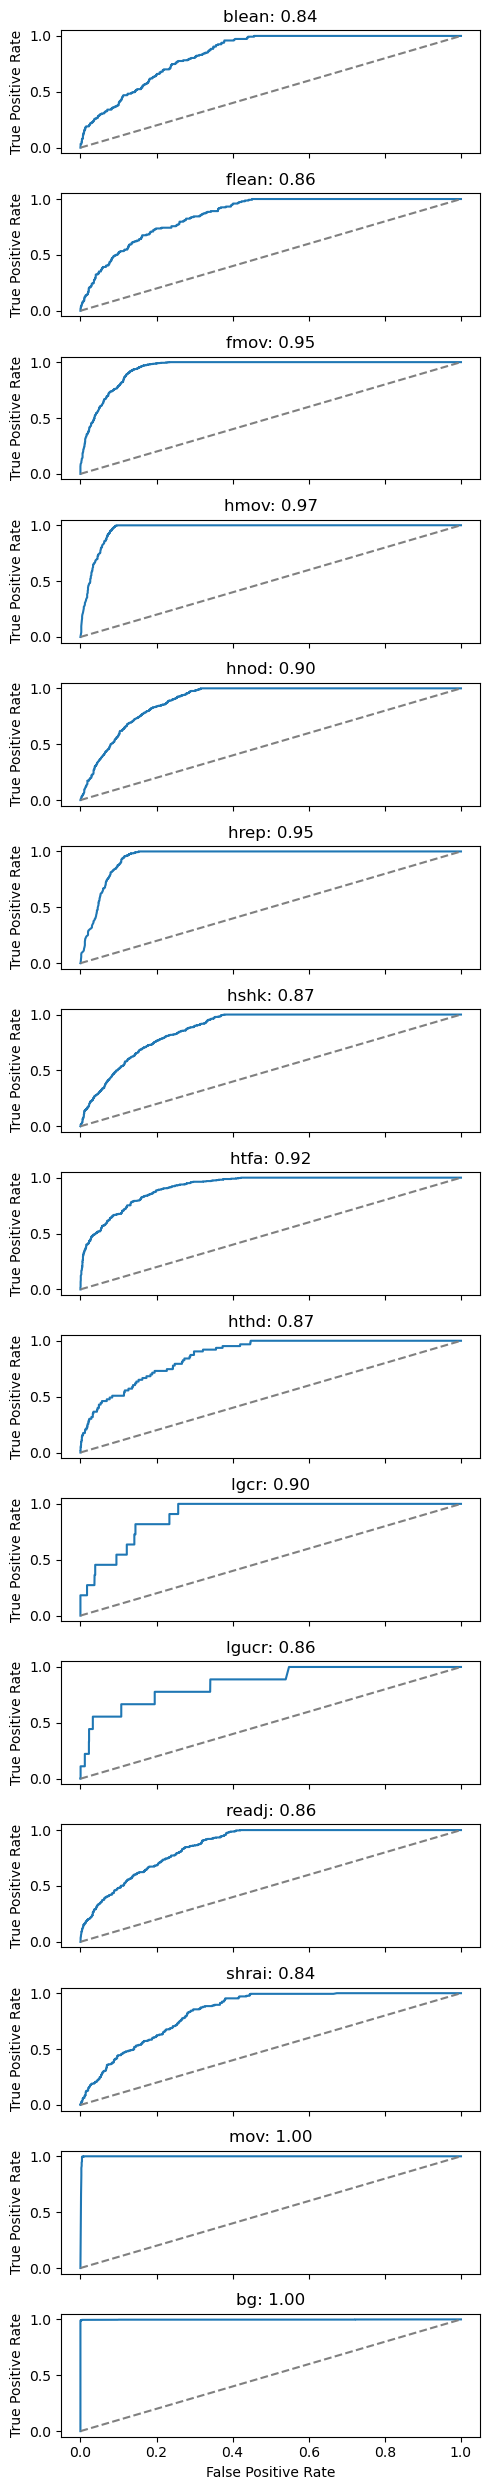

In [24]:
# Plot ROC curves and display additional information
# fig, axes = plt.subplots(nrows=1, ncols=len(roc_metrics), figsize=(15, 5))
num_lables = len(roc_metrics)
fig, axes = plt.subplots(nrows=num_lables, ncols=1, figsize=(5, 25))

for i, (label, metrics) in enumerate(roc_metrics.items()):
    tpr = metrics['tpr']
    fpr = metrics['fpr']
    auc = metrics['auc']
    auc_value = metrics['auc']

    # Plot ROC curve
    axes[i].plot(fpr, tpr, label=f'AUC = {auc_value:.2f}')
    axes[i].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')

    # Add title, AUC value, and additional information

    # axes[i].set_title(label)
    axes[i].set_title(f'{label}: {auc_value:.2f}')
    # axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    # if i==0:
    if i == num_lables-1:
        # axes[i].set_ylabel('True Positive Rate')
        axes[i].set_xlabel('False Positive Rate')
    # axes[i].legend(loc='lower right')
    else:
        # axes[i].set_yticklabels([])
        axes[i].set_xticklabels([])

    # Add text with additional information
    # axes[i].text(0.5, 0.1, f'True: {true_counts[label]}\nCorrect: {correct_counts[label]}\nMisclassified: {misclassified_counts[label]}',
    #              ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

    

In [25]:
# Gap analysis on lower predictions
detection_th = 0.8
sum_variables = ['micro avg', 'weighted avg','samples avg','macro avg']
bad_features = df_report.loc[df_report['f1-score']<detection_th]
bad_features_list = [a for a in bad_features.index if a not in sum_variables]
print(f'bad features: {bad_features_list}')

good_features = df_report.loc[df_report['f1-score']>=detection_th]
good_features_list = [a for a in good_features.index if a not in sum_variables]
print(f'good features: {good_features_list}')

bad features: ['blean', 'flean', 'hnod', 'hshk', 'htfa', 'hthd', 'lgcr', 'lgucr', 'readj', 'shrai']
good features: ['fmov', 'hmov', 'hrep', 'mov', 'bg']


In [26]:
logits.columns

Index(['logit-blean', 'logit-flean', 'logit-fmov', 'logit-hmov', 'logit-hnod',
       'logit-hrep', 'logit-hshk', 'logit-htfa', 'logit-hthd', 'logit-lgcr',
       'logit-lgucr', 'logit-readj', 'logit-shrai', 'logit-mov', 'logit-bg'],
      dtype='object')

In [27]:
selected_feature = 'lgcr'
# temp_df = df_optimal_preds[[selected_feature]].copy()
temp_df = logits[[f'logit-{selected_feature}']].copy()
temp_df = temp_df.rename(columns={'logit-'+selected_feature: selected_feature})
temp_df['correct'] = (temp_df[selected_feature]>0.5) == gt[f'gt-{selected_feature}']
FN = temp_df.loc[(~temp_df['correct'])&(gt[f'gt-{selected_feature}']==1)]
FP = temp_df.loc[(~temp_df['correct'])&(gt[f'gt-{selected_feature}']==0)]
TP = temp_df.loc[(temp_df['correct'])&(gt[f'gt-{selected_feature}']==1)]

In [28]:
print(f'{FN=}')
print(f'{FP=}')
print(f'{TP=}')

FN=                                                        lgcr  correct
filenames                                                            
/videos/mpi_data/2Itzik/dyadic_communication/SP...  0.144043    False
/videos/mpi_data/2Itzik/dyadic_communication/SP...  0.005981    False
/videos/mpi_data/2Itzik/dyadic_communication/SP...  0.021744    False
/videos/mpi_data/2Itzik/dyadic_communication/SP...  0.000431    False
/videos/mpi_data/2Itzik/dyadic_communication/SP...  0.066711    False
/videos/mpi_data/2Itzik/dyadic_communication/SP...  0.009300    False
/videos/mpi_data/2Itzik/dyadic_communication/SP...  0.000249    False
/videos/mpi_data/2Itzik/dyadic_communication/SP...  0.005344    False
/videos/mpi_data/2Itzik/dyadic_communication/SP...  0.069519    False
FP=                                                        lgcr  correct
filenames                                                            
/videos/mpi_data/2Itzik/dyadic_communication/SP...  0.522949    False
/videos/mpi_da

In [30]:
print(FN.index[0])

/videos/mpi_data/2Itzik/dyadic_communication/SPLIT/PIS_ID_02/Cam3/left/0108.mp4


In [33]:
df_csv.loc[df_csv['filenames']=='/videos/mpi_data/2Itzik/dyadic_communication/SPLIT/PIS_ID_02/Cam3/left/0108.mp4']

,Unnamed: 0,filenames,labels
394,394,/videos/mpi_data/2Itzik/dyadic_communication/S...,[1 1 1 1 1 1 0 0 0 1 0 1 0 1 0]


In [34]:
feature_names

['blean',
 'flean',
 'fmov',
 'hmov',
 'hnod',
 'hrep',
 'hshk',
 'htfa',
 'hthd',
 'lgcr',
 'lgucr',
 'readj',
 'shrai',
 'mov',
 'bg']